# Networks

## Exploring how billboards and signage affect our subconscious patterns

#### CDP '24: Mapping Systems, Assignment 03

### Part 1
Using a dataset of billboards and signage, we extract the metadata of the images to geolocate them, then we extract the labeled regions, and run a pre-trained model to extract the labels for them. This gives us a data set of labels to coordinates on the map.

The data comes from: https://www.kaggle.com/datasets/mekabytes/billboards-signs-and-branding/data

```
This is release 2022-08-07T10:22:40Z of the dataset billboards-signs-and-branding created 
on MekaBytes.com. A full list of contributors can be found below.
This particular download exists thanks to user TACIXAT. 
It was generated on 2022-08-11 at 02:02:08.

=== CONTRIBUTORS ===
douglas
coffee
Nixums
TACIXAT
```

In [3]:
%matplotlib ipympl

import pyogrio as ogr
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
import geopandas as gpd
import lonboard
from lonboard import Map, PolygonLayer
from lonboard.colormap import apply_categorical_cmap
import contextily as ctx
import pandas as pd
import seaborn as sns
import numpy as np
import folium
from folium.plugins import MarkerCluster
import h3
import os
from PIL import Image, ExifTags
from PIL import Image
from PIL.ExifTags import TAGS

I use the image metadata to find their coordinates so we can have a spatial dataset. 

In [15]:

def get_image_metadata(image_path):
    image = Image.open(image_path)
    exif = image._getexif()
    metadata = {}
    if exif:
        for tag_id, value in exif.items():
            tag = ExifTags.TAGS.get(tag_id, tag_id)
            metadata[tag] = value
        
        # Rotate image if necessary
        if "Orientation" in metadata:
            orientation = metadata["Orientation"]
            if orientation == 3:
                image = image.rotate(180, expand=True)
            elif orientation == 6:
                image = image.rotate(270, expand=True)
            elif orientation == 8:
                image = image.rotate(90, expand=True)
    
    # Convert image to numpy array
    image_array = np.array(image)
    
    return metadata, image_array

def extract_lat_long(metadata):
    gps_info = metadata.get('GPSInfo', {})
    if not gps_info:
        return None

    lat = gps_info.get(2)
    lon = gps_info.get(4)
    lat_ref = gps_info.get(1)
    lon_ref = gps_info.get(3)

    if lat and lon and lat_ref and lon_ref:
        lat = float(lat[0]) + float(lat[1]) / 60 + float(lat[2]) / 3600
        lon = float(lon[0]) + float(lon[1]) / 60 + float(lon[2]) / 3600
        
        lat *= -1 if lat_ref != 'N' else 1
        lon *= -1 if lon_ref != 'E' else 1
        
        return Point(lon, lat)
    else:
        return None

def process_images_in_directory(directory):
    images = [f for f in os.listdir(directory) if f.endswith('.jpg')]
    results = []
    for image in images:
        image_path = os.path.join(directory, image)
        metadata, image_array = get_image_metadata(image_path)
        point = extract_lat_long(metadata)
        if point:
            results.append((image, point, image_array))
    return results

# Example usage
directory = '../Data/billboards-signs-and-branding.2022-08-11T185322Z/images'
results = process_images_in_directory(directory)


In [16]:
def create_geopandas_dataframe(results):
    data = {
        'Image': [result[0] for result in results],
        'Point': [result[1] for result in results],
        'ImageArray': [result[2] for result in results]
    }
    gdf = gpd.GeoDataFrame(data, geometry='Point')
    return gdf

# Example usage
gdf = create_geopandas_dataframe(results)
print(gdf)



                                  Image                        Point  \
0   WittyWorthlessIrishdraughthorse.jpg  POINT (-118.39898 34.06248)   
1    StudiousMemorableDesertpupfish.jpg  POINT (-118.34421 34.07273)   
2                 VainWebbedIchidna.jpg  POINT (-118.34425 34.07607)   
3             MistyroseWornShibainu.jpg  POINT (-118.34885 34.07605)   
4                LikelyGaseousJunco.jpg  POINT (-118.34389 34.06954)   
..                                  ...                          ...   
92         PowerfulOrdinaryHousefly.jpg  POINT (-118.34404 34.07520)   
93        FinishedTruthfulDromedary.jpg  POINT (-118.35306 34.07043)   
94      InstructiveLightyellowLarva.jpg  POINT (-118.39920 34.06712)   
95           MeagerFilthyQueenconch.jpg  POINT (-118.35143 34.07013)   
96           DistantGaseousNematode.jpg  POINT (-118.35342 34.07051)   

                                           ImageArray  
0   [[[67, 62, 43], [68, 63, 44], [65, 60, 41], [6...  
1   [[[95, 134, 191], [

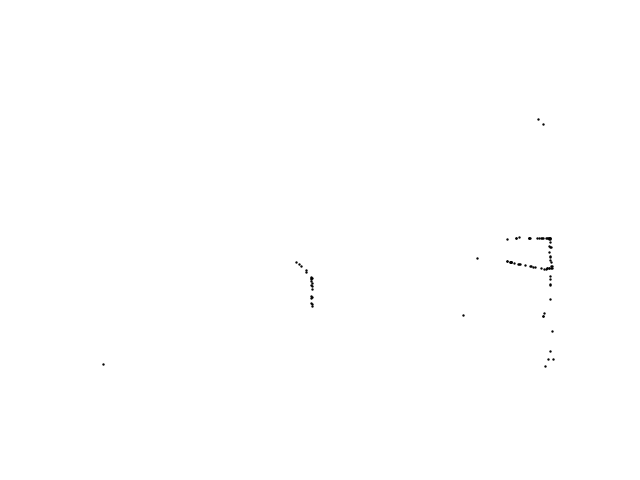

In [20]:
ax = gdf.plot(marker='o', color='black', markersize=0.5).set_axis_off()

I then extract the regions provided by the annotations in the dataset, and pass them through a labeling ML model to obtain labels for each photo.

starting preduction
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
[('n03666591', 'lighter', 0.15249522), ('n03291819', 'envelope', 0.059268348), ('n07248320', 'book_jacket', 0.058444988)]
starting preduction
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
[('n04149813', 'scoreboard', 0.24849398), ('n02840245', 'binder', 0.13096075), ('n03871628', 'packet', 0.05228677)]
starting preduction
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
[('n02971356', 'carton', 0.5510559), ('n07248320', 'book_jacket', 0.0930161), ('n03891332', 'parking_meter', 0.014504286)]


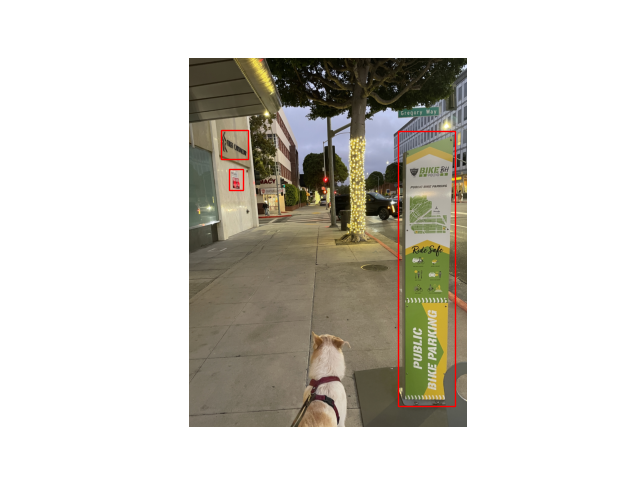

starting preduction
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
[('n06359193', 'web_site', 0.6343839), ('n03291819', 'envelope', 0.067060225), ('n03196217', 'digital_clock', 0.017028606)]


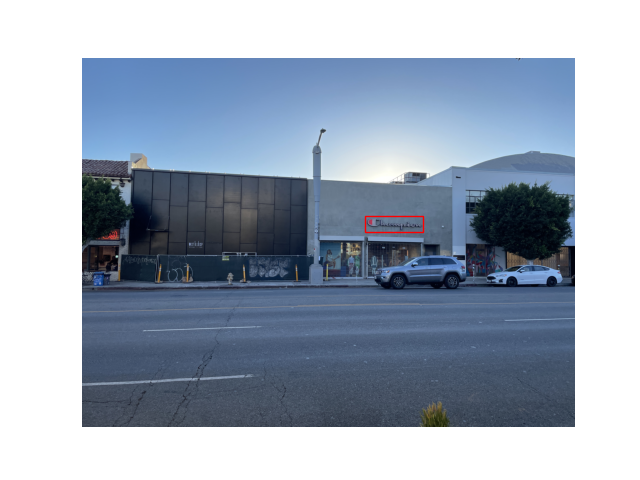

starting preduction
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
[('n03197337', 'digital_watch', 0.13497254), ('n02708093', 'analog_clock', 0.061544213), ('n03196217', 'digital_clock', 0.048172686)]
starting preduction
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
[('n03196217', 'digital_clock', 0.37368527), ('n03197337', 'digital_watch', 0.17183663), ('n04270147', 'spatula', 0.07786469)]
starting preduction
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
[('n04404412', 'television', 0.40826294), ('n06359193', 'web_site', 0.07602215), ('n03782006', 'monitor', 0.044531383)]
starting preduction
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
[('n04404412', 'television', 0.1822667), ('n06359193', 'web_site', 0.16044037), ('n02992529', 'cellular_telephone', 0.119118236)]
starting preduction
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
[('n04149813', 'scoreboard', 0.6717305), ('n03425413', 'gas_pump', 0.06493041), ('n03891332', 'parking_meter', 0.033471443)]
starting preduction
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
[('n09229709', '

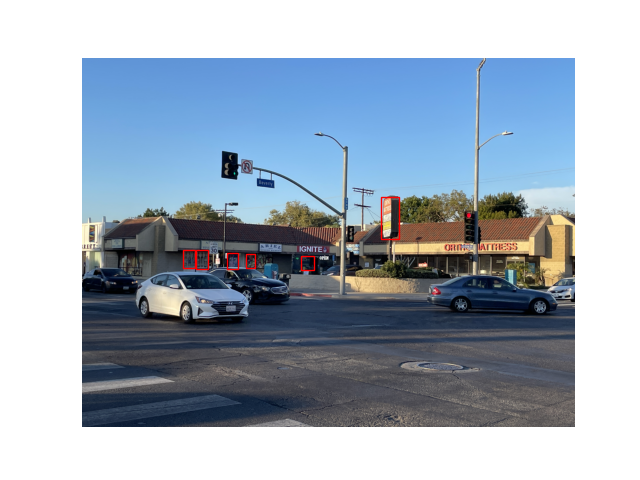

starting preduction
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
[('n03032252', 'cinema', 0.49995196), ('n04149813', 'scoreboard', 0.13547756), ('n06794110', 'street_sign', 0.07840084)]
starting preduction
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
[('n02971356', 'carton', 0.35257378), ('n03843555', 'oil_filter', 0.16406277), ('n03127925', 'crate', 0.08516661)]
starting preduction
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
[('n04443257', 'tobacco_shop', 0.19832927), ('n04149813', 'scoreboard', 0.19799533), ('n03032252', 'cinema', 0.113959804)]
starting preduction
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
[('n07248320', 'book_jacket', 0.6394795), ('n06596364', 'comic_book', 0.11337564), ('n04443257', 'tobacco_shop', 0.054913677)]
starting preduction
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
[('n02971356', 'carton', 0.8007668), ('n03291819', 'envelope', 0.06300952), ('n02840245', 'binder', 0.023332918)]
starting preduction
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
[('n03710193', 'mailbox', 0.27212834), ('n04525305',

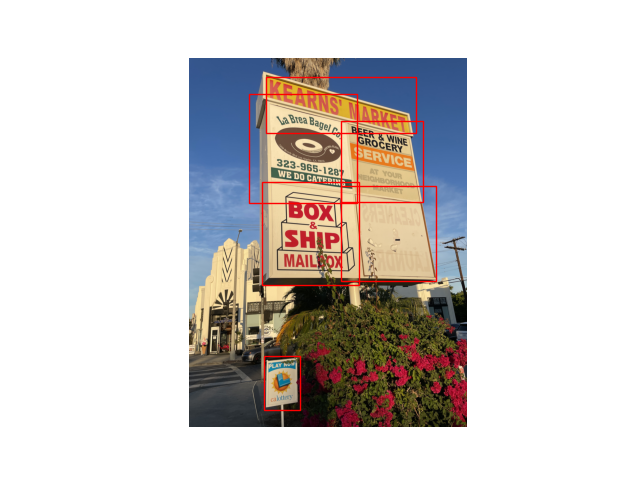

In [18]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
import matplotlib.patches as patches
import os

debug = False

# Load the pre-trained ResNet50 model
model = ResNet50(weights='imagenet')
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

def get_image_labels(image_array):
    # Resize the image while maintaining aspect ratio
    print('starting preduction')
    target_size = (224, 224)
    img = tf.image.resize_with_pad(image_array, target_size[0], target_size[1])
    
    # Convert to a writable numpy array
    img = img.numpy().astype(np.float32)
    
    # Expand dimensions
    x = np.expand_dims(img, axis=0)
    
    # Preprocess the input
    x = preprocess_input(x)
    
    # Make predictions
    preds = model.predict(x)
    
    # Decode predictions
    labels = decode_predictions(preds, top=3)[0]
    print(labels)
    return labels

def extract_region(image_array, coords):
    x_min, y_min, x_max, y_max = coords
    img_height, img_width, _ = image_array.shape
    x_min = max(0, int(x_min * img_width))
    x_max = min(img_width, int(x_max * img_width))
    y_min = max(0, int(y_min * img_height))
    y_max = min(img_height, int(y_max * img_height))
    
    # Check if the region is valid
    if x_min >= x_max or y_min >= y_max:
        return None
    
    region = image_array[y_min:y_max, x_min:x_max]

    # Display the region image (for debugging)
    if debug:
        plt.imshow(region.astype(np.uint8))
        plt.axis('off')
        plt.show()
    
    # Check if the region is not empty
    if region.size == 0:
        return None
    if region.shape[0] < 100 or region.shape[1] < 80:
        return None
    
    return region

# Paths
annotations_base = "/Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/billboards-signs-and-branding.2022-08-11T185322Z/annotations"

# Initialize the 'Labels' column with empty lists
gdf['Labels'] = [[] for _ in range(len(gdf))]

# Iterate through every row
for idx, row in gdf.head(4).iterrows():
    image_labels = []
    annotation_path = os.path.join(annotations_base, row['Image'].replace('.jpg', '.csv'))
    
    # Load its annotation file
    if os.path.exists(annotation_path):
        annotations = pd.read_csv(annotation_path)

        if debug:
            img_array = row['ImageArray']
            fig, ax = plt.subplots(1)
            ax.imshow(img_array.astype(np.uint8))
        
        # Iterate through the annotated regions
        for _, annotation in annotations.iterrows():
            coords = (annotation['x1'], annotation['y1'], annotation['x2'], annotation['y2'])
            region = extract_region(img_array, coords)
            if region is None:
                continue
            
            if debug:
                # Draw rectangle on the image
                x_min, y_min, x_max, y_max = coords
                img_height, img_width, _ = img_array.shape
                x_min = max(0, int(x_min * img_width))
                x_max = min(img_width, int(x_max * img_width))
                y_min = max(0, int(y_min * img_height))
                y_max = min(img_height, int(y_max * img_height))
                
                rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
            
            labels = get_image_labels(region)
            image_labels.extend(labels) 
        
        if debug:
            plt.axis('off')
            plt.show()
    
    gdf.at[idx, 'Labels'] = image_labels

In [13]:
# Convert the 'Labels' column to a format that GeoJSON supports
def convert_labels_to_geojson_format(labels):
    # Discard the first element of the tuple, only include the label, and remove duplicates
    filtered_labels = ', '.join(set([label[1] for label in labels]))
    return filtered_labels

gdf_filtered = gdf.copy()
gdf_filtered = gdf_filtered.drop(columns=['ImageArray'])
gdf_filtered['Labels'] = gdf_filtered['Labels'].apply(convert_labels_to_geojson_format)



In [14]:
# Save the GeoDataFrame to a file
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d%H%M")
output_file = f"/Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/billboards-signs-and-branding.2022-08-11T185322Z/processed_annotations_{timestamp}.geojson"
gdf_filtered.to_file(output_file, driver='GeoJSON')
print(f"GeoDataFrame saved to {output_file}")


GeoDataFrame saved to /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/billboards-signs-and-branding.2022-08-11T185322Z/processed_annotations_202408102228.geojson


In [5]:

# Read the GeoDataFrame from the file
gdf_filtered = gpd.read_file("/Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/billboards-signs-and-branding.2022-08-11T185322Z/processed_annotations_202408102228.geojson")
print("GeoDataFrame read from file successfully")


GeoDataFrame read from file successfully


Interactive map saved to /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/billboards-signs-and-branding.2022-08-11T185322Z/interactive_map.html



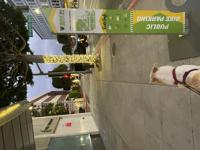
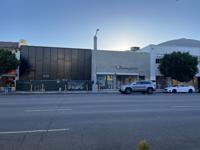
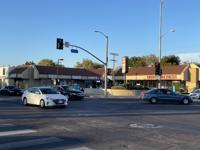
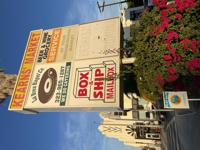
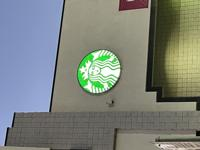
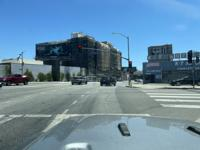
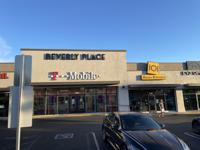
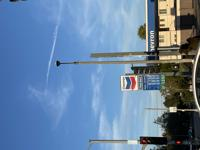
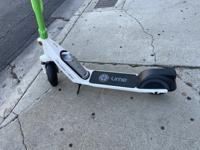
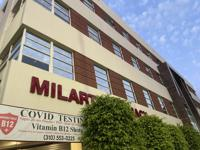
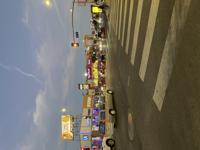
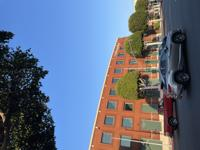
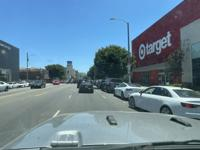
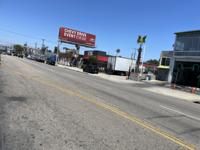
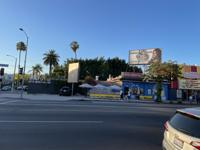
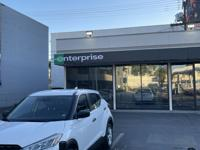
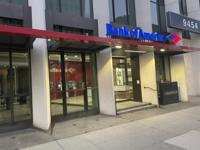
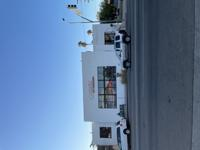
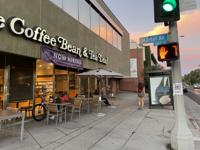
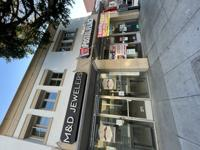
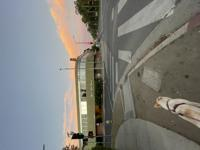
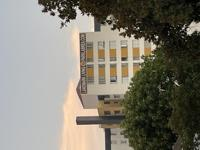
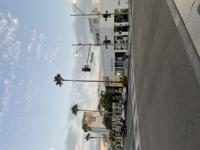
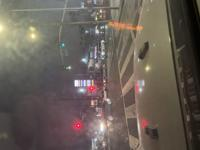
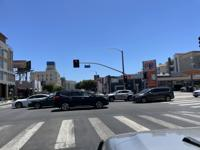
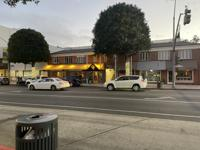
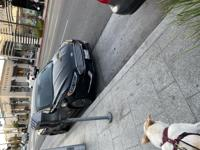
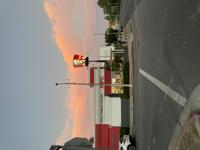
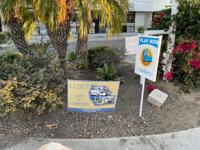
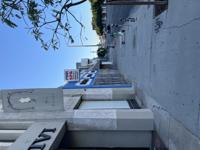
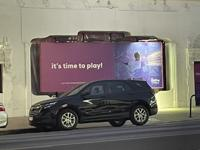
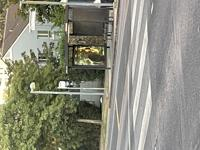
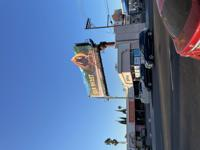
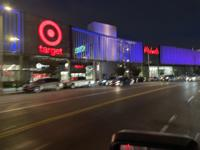
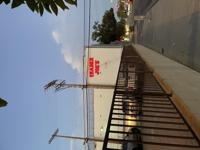
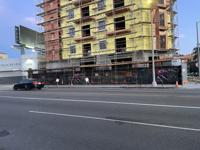
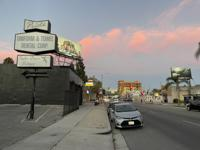
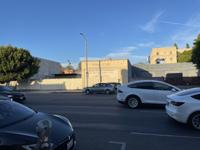
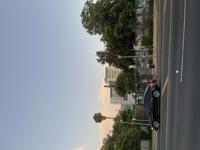
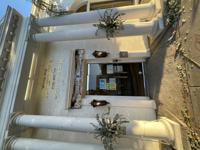
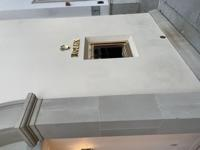
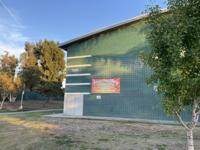
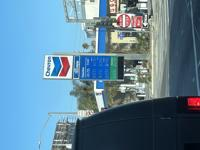
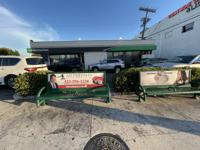
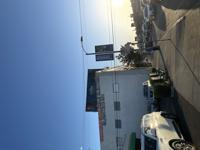
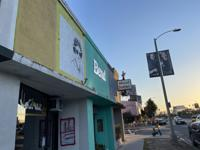
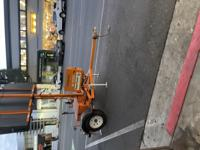
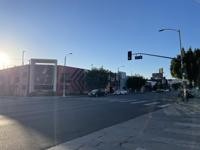
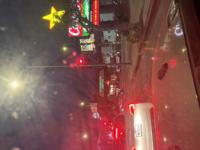
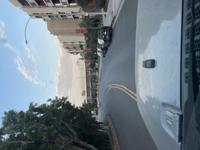
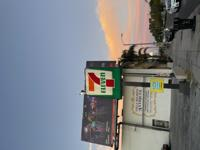
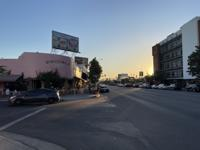
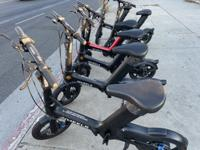
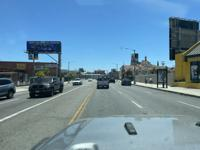
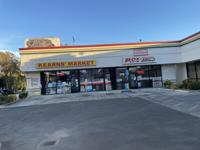
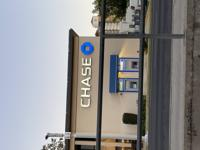
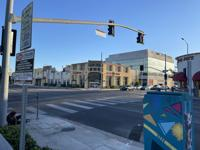
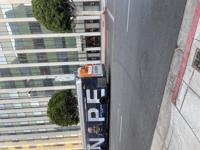
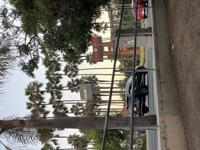
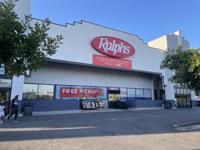
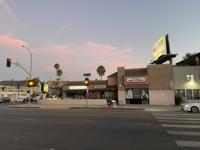
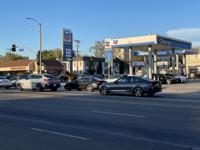
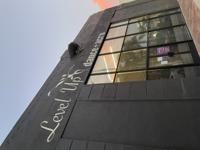
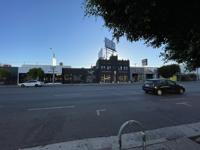
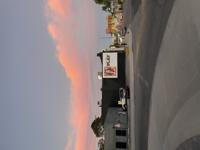
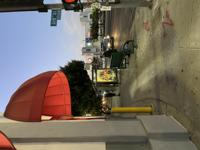
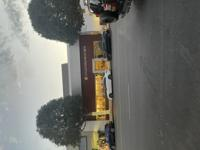
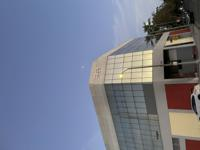
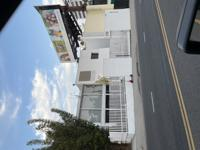
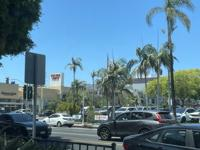
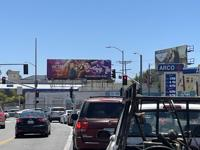
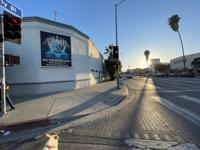
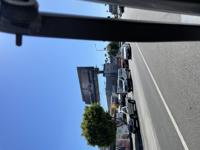
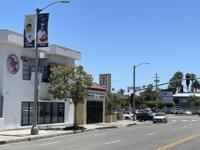
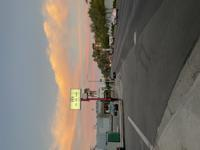
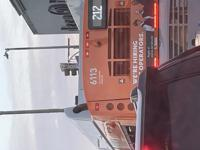
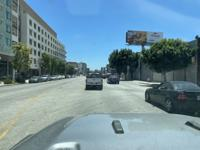
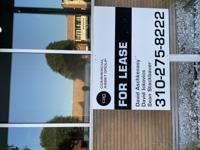
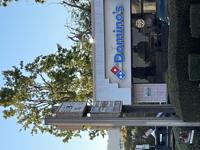
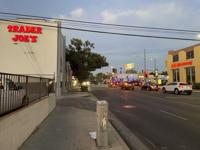
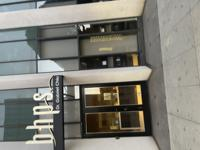
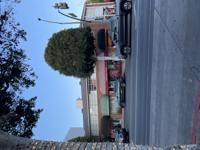
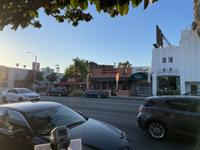
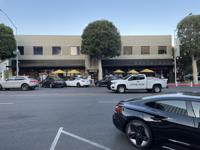
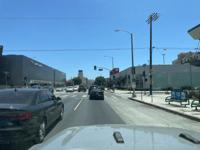
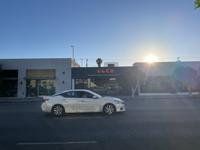
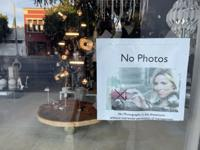
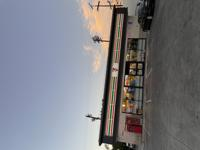
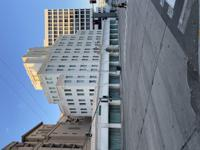
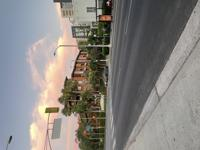
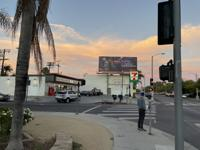

In [15]:
import folium
from folium.plugins import MarkerCluster
from PIL import Image

# Create a map centered around the average coordinates
m = folium.Map(location=[gdf_filtered.geometry.y.mean(), gdf_filtered.geometry.x.mean()], zoom_start=14, tiles="Cartodb Positron")

# Add a marker cluster to the map
marker_cluster = MarkerCluster().add_to(m)

base = "/Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/billboards-signs-and-branding.2022-08-11T185322Z/images"
# Add points to the map with hover labels
for idx, row in gdf_filtered.iterrows():
    if row['Labels'] == '':
        continue
    image_path = os.path.join(base, row['Image'])
    small_image_path = os.path.join(base, f"small_{row['Image']}")
    
    # Create a small 100x100 copy of the image
    with Image.open(image_path) as img:
        img.thumbnail((200, 200))
        img.save(small_image_path)
    
    folium.Marker(
        location=[row['Point'].y, row['Point'].x],
        popup=row['Labels'],
        icon=folium.features.CustomIcon(icon_image=small_image_path, icon_size=(100,100))
    ).add_to(marker_cluster)

# Save the map to an HTML file
output_map_file = "/Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/billboards-signs-and-branding.2022-08-11T185322Z/interactive_map.html"
m.save(output_map_file)
print(f"Interactive map saved to {output_map_file}")

# Display the map in the notebook
m


Now we visualize which nodes are connected because they share the same label. It seems that the model I used is not ideal for recognizing logos and branding, so it produced a series of hallucinated labels that are vaguely related to the image snippets. I actually find this more interesting, because it faintly alludes to what a human subconscious might process while driving past one of these billboards.

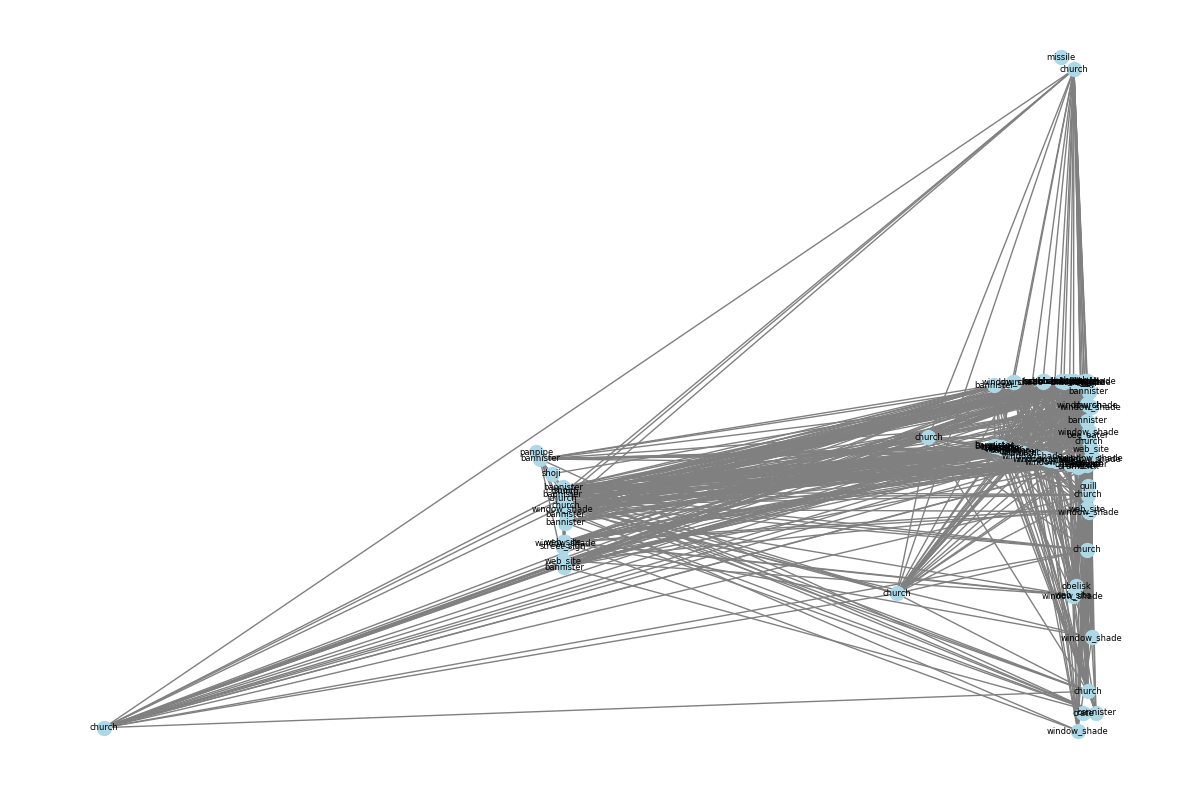

Number of nodes: 91
Number of edges: 677
Number of connected components: 19


In [21]:
import networkx as nx

# Create a graph
G = nx.Graph()

# Add nodes with labels and positions based on their geometry
for idx, row in gdf_filtered.iterrows():
    if row['Labels'] and isinstance(row.geometry, Point):  # Check if Labels is not empty and geometry is valid
        labels = row['Labels'].split(',')
        for label in labels:
            G.add_node(idx, label=label.strip(), pos=(row.geometry.x, row.geometry.y))

# Add edges between nodes with the same label
for label in set(label.strip() for labels in gdf_filtered['Labels'].dropna() for label in labels.split(',')):
    nodes_with_label = [idx for idx, row in G.nodes(data=True) if row['label'] == label]
    for i in range(len(nodes_with_label)):
        for j in range(i + 1, len(nodes_with_label)):
            G.add_edge(nodes_with_label[i], nodes_with_label[j])

# Draw the graph with nodes positioned based on their geometry
pos = nx.get_node_attributes(G, 'pos')
labels = nx.get_node_attributes(G, 'label')

plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=False, node_color='lightblue', edge_color='gray', node_size=100)
nx.draw_networkx_labels(G, pos, labels, font_size=6)
plt.title("Nodes sharing the same label")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# Print some statistics about the graph
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Number of connected components: {nx.number_connected_components(G)}")


In [24]:
import osmnx as ox
bounds = gdf_filtered.total_bounds
bb_net = ox.graph_from_bbox(
    bounds[1], bounds[3], bounds[0], bounds[2], network_type='drive'
)
nodes, edges = ox.graph_to_gdfs(bb_net)

/var/folders/1_/c48g_s_x3g742m1fsz_ytz840000gn/T/ipykernel_4913/1500831895.py:3: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  bb_net = ox.graph_from_bbox(


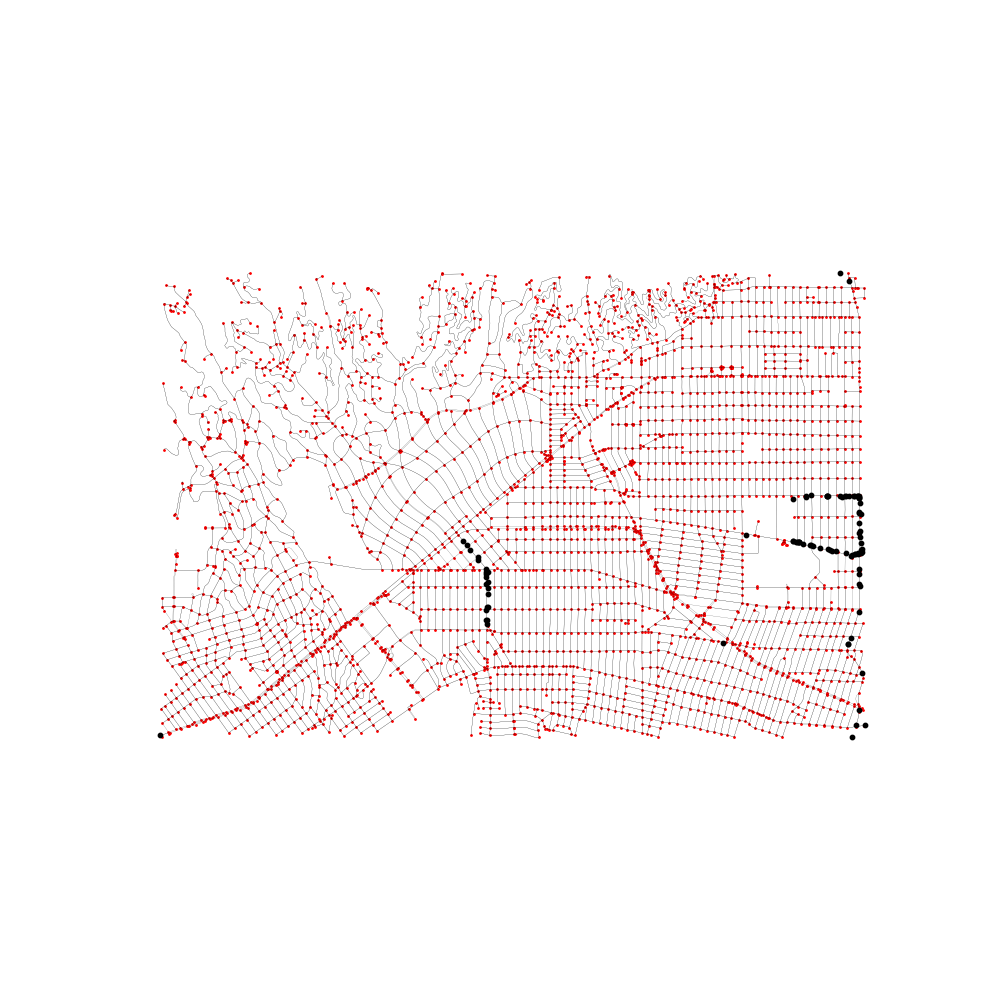

In [29]:
ax = edges.plot(color='black', linewidth=0.1, figsize=(10,10))
nodes.plot(ax=ax, color='red', markersize=1).set_axis_off()
# Overlay the nodes from our data
gdf_filtered.plot(ax=ax, color='black', markersize=10)

plt.show()


/var/folders/1_/c48g_s_x3g742m1fsz_ytz840000gn/T/ipykernel_4913/4139483070.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  path_length = sum(ox.utils_graph.get_route_edge_attributes(bb_net, path, 'length'))


Shortest path between two 'church' nodes: [24960532, 123000469, 122554546, 123000472, 123000475, 122865673, 123000478, 123000480, 123000482, 123000485, 123000489, 122784491, 123000490, 122626055, 122633378, 122750478, 123000492, 123000494, 123000496, 122978681, 123000499, 123000501, 123000505, 123000507, 1718692981, 122656908, 122675168, 123000513, 123000516, 123000518, 18166155, 123622781, 122764493, 1717893549, 123709727, 123420140, 122657092, 123248226, 122737577, 1717893592, 1717893706, 1717893647, 1717893679, 1717893781, 1717893594, 1717893750, 123709736, 123631822, 122668659, 122668658, 123059403, 123172016, 123519409, 123191706, 123191708, 123191711]
Path length: 5977.596000000001 meters


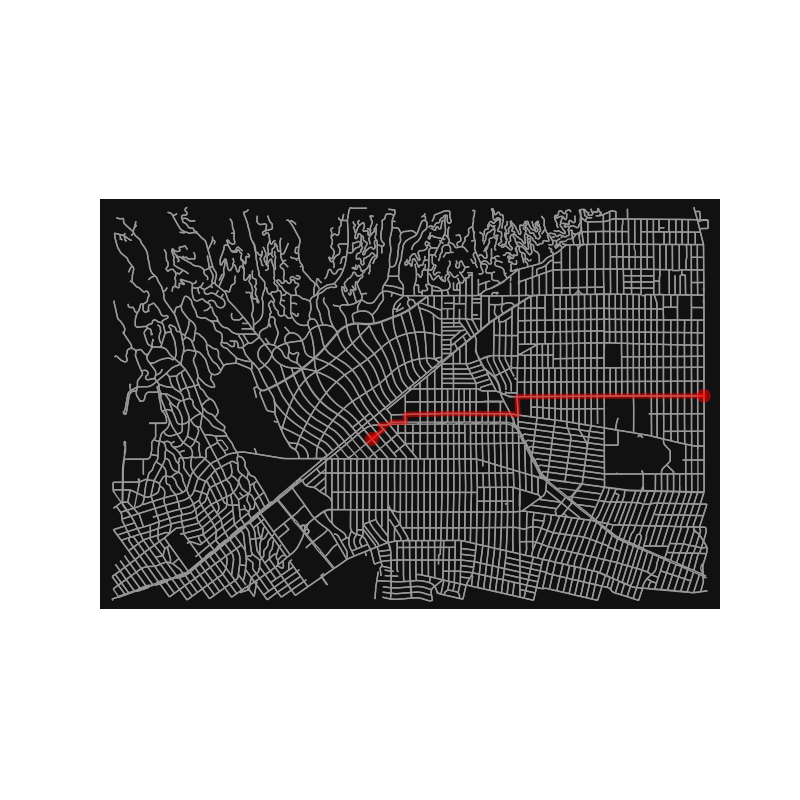

In [44]:
import osmnx as ox
import networkx as nx

# Find nodes with the label 'church'
church_nodes = gdf_filtered[gdf_filtered['Labels'].str.contains('church', case=False, na=False)]

if len(church_nodes) >= 2:
    # Get the first two church nodes
    source = church_nodes.iloc[0]
    target = church_nodes.iloc[15]

    # Find the nearest nodes in bb_net to the source and target nodes
    source_nearest = ox.distance.nearest_nodes(bb_net, source.geometry.x, source.geometry.y)
    target_nearest = ox.distance.nearest_nodes(bb_net, target.geometry.x, target.geometry.y)
    
    try:
        path = ox.shortest_path(bb_net, source_nearest, target_nearest, weight='length')
        path_length = sum(ox.utils_graph.get_route_edge_attributes(bb_net, path, 'length'))
        
        # Print the path and its length
        print(f"Shortest path between two 'church' nodes: {path}")
        print(f"Path length: {path_length} meters")
        
        fig, ax = ox.plot_graph_route(bb_net, path, node_size=0)
    except nx.NetworkXNoPath:
        print("No path exists between the two 'church' nodes.")
else:
    print("There are less than two nodes with the label 'church'.")



Now we create a new graph heavily reducing the weights of nodes with the label 'church', such that you can get directions from arbitrary points that will maximize the likelihood of passing near signage that reminds you of church. 

/var/folders/1_/c48g_s_x3g742m1fsz_ytz840000gn/T/ipykernel_4913/3764164894.py:40: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  path_length = sum(ox.utils_graph.get_route_edge_attributes(bb_net, path, 'length'))


Path from (-118.4053, 34.0535) to (-118.3637, 34.1010)
Path length: 9334.01 meters
Number of church nodes passed: 4


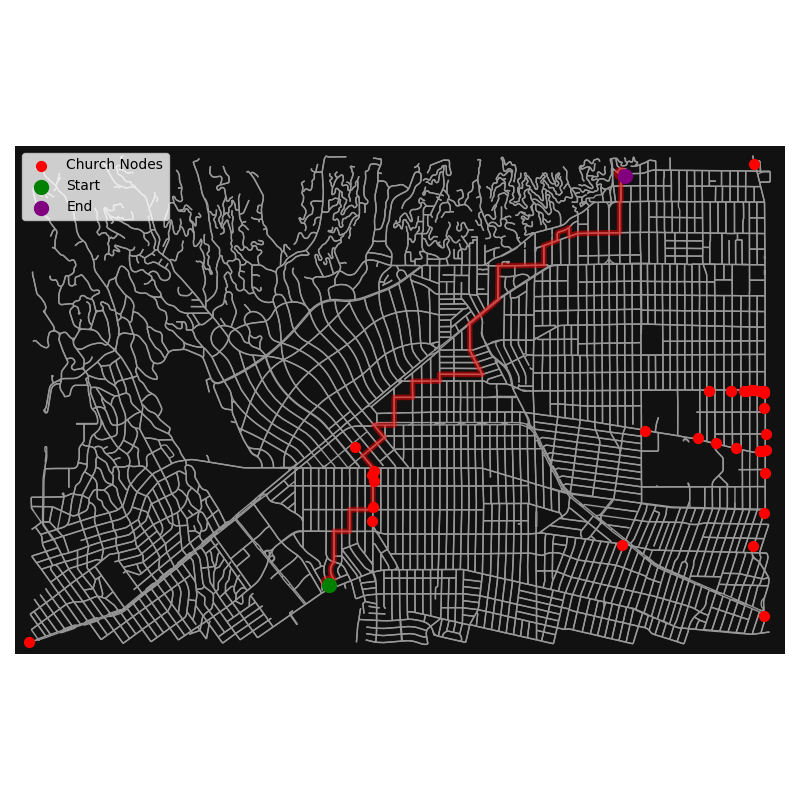

In [51]:
import osmnx as ox
import networkx as nx
import random
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Find nodes with the label 'church'
church_nodes = gdf_filtered[gdf_filtered['Labels'].str.contains('church', case=False, na=False)]

# Get the bounds of the map
bounds = gdf_filtered.total_bounds  # (minx, miny, maxx, maxy)

if len(church_nodes) >= 1:
    # Generate two random points within the bounds
    start_point = Point(random.uniform(bounds[0], bounds[2]), random.uniform(bounds[1], bounds[3]))
    end_point = Point(random.uniform(bounds[0], bounds[2]), random.uniform(bounds[1], bounds[3]))

    # Find the nearest nodes in bb_net to the start and end points
    start_nearest = ox.distance.nearest_nodes(bb_net, start_point.x, start_point.y)
    end_nearest = ox.distance.nearest_nodes(bb_net, end_point.x, end_point.y)

    # Create a copy of bb_net and modify edge weights
    G_modified = bb_net.copy()
    
    # Set a high default weight for all edges
    for u, v, data in G_modified.edges(data=True):
        G_modified[u][v][0]['weight'] = 1000  # High weight to discourage passing through

    # Set a small weight for edges near church nodes
    for _, church_node in church_nodes.iterrows():
        nearest_church = ox.distance.nearest_nodes(G_modified, church_node.geometry.x, church_node.geometry.y)
        for u, v, data in G_modified.edges(nearest_church, data=True):
            G_modified[u][v][0]['weight'] = 0.001  # Small weight to encourage passing through

    try:
        # Find the shortest path using the modified weights
        path = nx.shortest_path(G_modified, start_nearest, end_nearest, weight='weight')
        
        # Calculate the actual path length using the original network
        path_length = sum(ox.utils_graph.get_route_edge_attributes(bb_net, path, 'length'))
        
        # Count how many church nodes the path passes near
        church_count = sum(1 for _, church_node in church_nodes.iterrows() 
                           if ox.distance.nearest_nodes(bb_net, church_node.geometry.x, church_node.geometry.y) in path)
        
        # Print the results
        print(f"Path from ({start_point.x:.4f}, {start_point.y:.4f}) to ({end_point.x:.4f}, {end_point.y:.4f})")
        print(f"Path length: {path_length:.2f} meters")
        print(f"Number of church nodes passed: {church_count}")
        
        # Plot the route
        fig, ax = ox.plot_graph_route(bb_net, path, node_size=0, show=False, close=False)
        
        # Plot church nodes
        church_x = church_nodes.geometry.x
        church_y = church_nodes.geometry.y
        ax.scatter(church_x, church_y, c='red', s=50, zorder=5, label='Church Nodes')
        
        # Plot start and end points
        ax.scatter(start_point.x, start_point.y, c='green', s=100, zorder=6, label='Start')
        ax.scatter(end_point.x, end_point.y, c='purple', s=100, zorder=6, label='End')
        
        ax.legend()
        plt.tight_layout()
        plt.show()
        
    except nx.NetworkXNoPath:
        print("No path exists between the selected points.")
else:
    print("There are no nodes with the label 'church'.")